In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
import ghibtools as gh
import pandas as pd
import seaborn as sns
import pingouin as pg
import neurokit2 as nk
from params import *
from bibliotheque import *
import physio
import scipy
import time
from compute_phase_freq import phase_freq_job, power_job, phase_freq_concat_job, erp_concat_job
from compute_resp_features import respiration_features_job
from preproc import convert_vhdr_job, eeg_interp_artifact_job, preproc_job
from compute_power_at_resp import power_at_resp_job
from compute_phase_freq import phase_freq_job
from compute_global_dataframes import hrv_concat_job
from compute_psd import psd_eeg_job
from compute_cycle_signal import cycle_signal_job

# PSD

In [10]:
rk = 'P05_odor'
psd_odor = psd_eeg_job.get(rk)['psd']
rk = 'P05_music'
psd_baseline = psd_eeg_job.get(rk)['psd']

In [9]:
psd

<xarray.DataArray 'psd' (chan: 31, freq: 25001)>
[775031 values with dtype=float64]
Coordinates:
  * chan     (chan) object 'Fp1' 'Fz' 'F3' 'F7' 'FT9' ... 'FC2' 'F4' 'F8' 'Fp2'
  * freq     (freq) float64 0.0 0.02 0.04 0.06 0.08 ... 499.9 500.0 500.0 500.0
Attributes:
    srate:    1000

In [11]:
psd_odor_norm = psd_odor.copy()

In [12]:
psd_odor_norm[:] = psd_odor.values / psd_baseline.values

[Text(0, 0, 'Fp1'),
 Text(1, 0, 'Fz'),
 Text(2, 0, 'F3'),
 Text(3, 0, 'F7'),
 Text(4, 0, 'FT9'),
 Text(5, 0, 'FC5'),
 Text(6, 0, 'FC1'),
 Text(7, 0, 'C3'),
 Text(8, 0, 'T7'),
 Text(9, 0, 'TP9'),
 Text(10, 0, 'CP5'),
 Text(11, 0, 'CP1'),
 Text(12, 0, 'Pz'),
 Text(13, 0, 'P3'),
 Text(14, 0, 'P7'),
 Text(15, 0, 'O1'),
 Text(16, 0, 'Oz'),
 Text(17, 0, 'O2'),
 Text(18, 0, 'P4'),
 Text(19, 0, 'P8'),
 Text(20, 0, 'TP10'),
 Text(21, 0, 'CP6'),
 Text(22, 0, 'CP2'),
 Text(23, 0, 'C4'),
 Text(24, 0, 'T8'),
 Text(25, 0, 'FT10'),
 Text(26, 0, 'FC6'),
 Text(27, 0, 'FC2'),
 Text(28, 0, 'F4'),
 Text(29, 0, 'F8'),
 Text(30, 0, 'Fp2')]

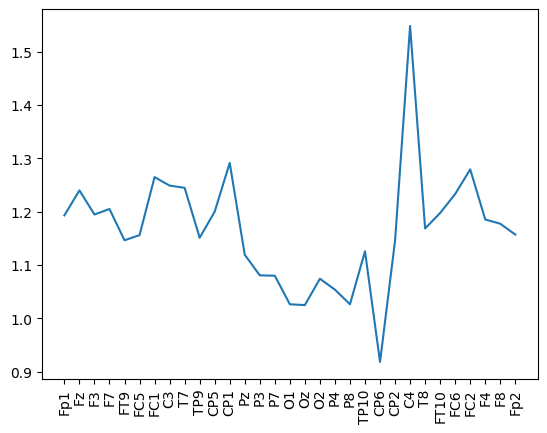

In [27]:
fig, ax = plt.subplots()
ax.plot(psd_odor_norm.sel(freq = slice(5,15)).mean('freq').values)
ax.set_xticks(np.arange(0,psd_odor_norm['chan'].size))
ax.set_xticklabels(psd_odor_norm['chan'].values, rotation = 90)
# ax.tick_params

In [3]:
rk = 'P05_odor'

In [7]:
sigs = eeg_interp_artifact_job.get(rk)['interp']
srate = sigs.attrs['srate']

In [8]:
sig = sigs.sel(chan = 'F3').values

In [29]:
f, Pxx = gh.spectre(sig, srate, lowest_freq = 0.1, verbose = True)

nperseg : 50000
sig size : 600000
total cycles lowest freq : 60
nwindows : 24


In [34]:
%matplotlib widget

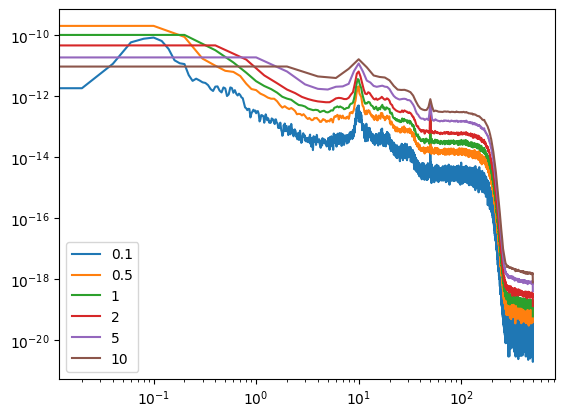

In [56]:
fig, ax = plt.subplots()

for i in [0.1, 0.5, 1, 2, 5, 10]:
    f, Pxx = gh.spectre(sig, srate, lowest_freq =i, verbose = False)
    ax.loglog(f, Pxx, label = i)
ax.legend()
# ax.set_xlim(8,12)
# ax.set_ylim(0, 0.2*1e-10)

In [38]:
power = power_job.get(rk)['power']

In [41]:
power = power.mean('time')

In [44]:
%matplotlib inline

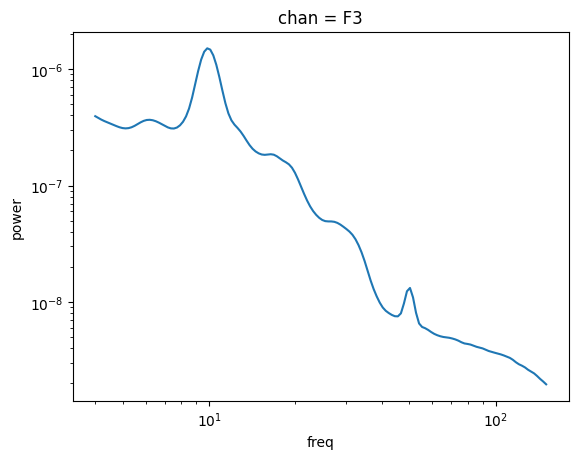

In [55]:
power.sel(chan = 'F3').plot.line(x = 'freq', hue = 'chan', yscale = 'log', xscale = 'log')

# CORRELATION RESPI HRV RSA

In [8]:
from compute_global_dataframes import hrv_concat_job, resp_features_concat_job, rsa_concat_job

In [13]:
hrv = hrv_concat_job.get(global_key).to_dataframe().groupby(['participant','session']).mean(True).reset_index(drop = True)
resp = resp_features_concat_job.get(global_key).to_dataframe().groupby(['participant','session']).mean(True).reset_index(drop = True)
rsa = rsa_concat_job.get(global_key).to_dataframe().groupby(['participant','session']).mean(True).reset_index(drop = True)

In [22]:
print(hrv.columns)
print(resp.columns)
print(rsa.columns)

Index(['HRV_Mean', 'HRV_SD', 'HRV_Median', 'HRV_Mad', 'HRV_CV', 'HRV_MCV',
       'HRV_Asymmetry', 'HRV_RMSSD', 'stai_state', 'stai_trait', 'Maia_Mean',
       'OAS', 'BMRQ'],
      dtype='object')
Index(['inspi_index', 'expi_index', 'next_inspi_index', 'inspi_time',
       'expi_time', 'next_inspi_time', 'cycle_duration', 'inspi_duration',
       'expi_duration', 'cycle_freq', 'cycle_ratio', 'inspi_volume',
       'expi_volume', 'total_amplitude', 'inspi_amplitude', 'expi_amplitude',
       'total_volume', 'artifact', 'stai_state', 'stai_trait', 'Maia_Mean',
       'OAS', 'BMRQ'],
      dtype='object')
Index(['peak_index', 'trough_index', 'peak_time', 'trough_time', 'peak_value',
       'trough_value', 'rising_amplitude', 'decay_amplitude',
       'rising_duration', 'decay_duration', 'rising_slope', 'decay_slope',
       'stai_state', 'stai_trait', 'Maia_Mean', 'OAS', 'BMRQ'],
      dtype='object')


In [27]:
hrv_sel = ['HRV_Mean', 'HRV_SD', 'HRV_Median', 'HRV_Mad', 'HRV_CV', 'HRV_MCV', 'HRV_RMSSD']
resp_sel = ['cycle_duration', 'cycle_ratio', 'total_amplitude',
       'total_volume']
rsa_sel = ['rising_amplitude', 'decay_amplitude',
       'rising_duration', 'decay_duration', 'rising_slope', 'decay_slope']

In [49]:
rename_resp = {metric:f'Resp {metric}' for metric in resp_sel}
rename_rsa = {metric:f'RSA {metric}' for metric in rsa_sel}

In [50]:
resp_rename = resp[resp_sel].rename(columns = rename_resp)
rsa_renale =  rsa[rsa_sel].rename(columns = rename_rsa)

In [52]:
concat = pd.concat([hrv[hrv_sel], resp_rename, rsa_renale], axis = 1)

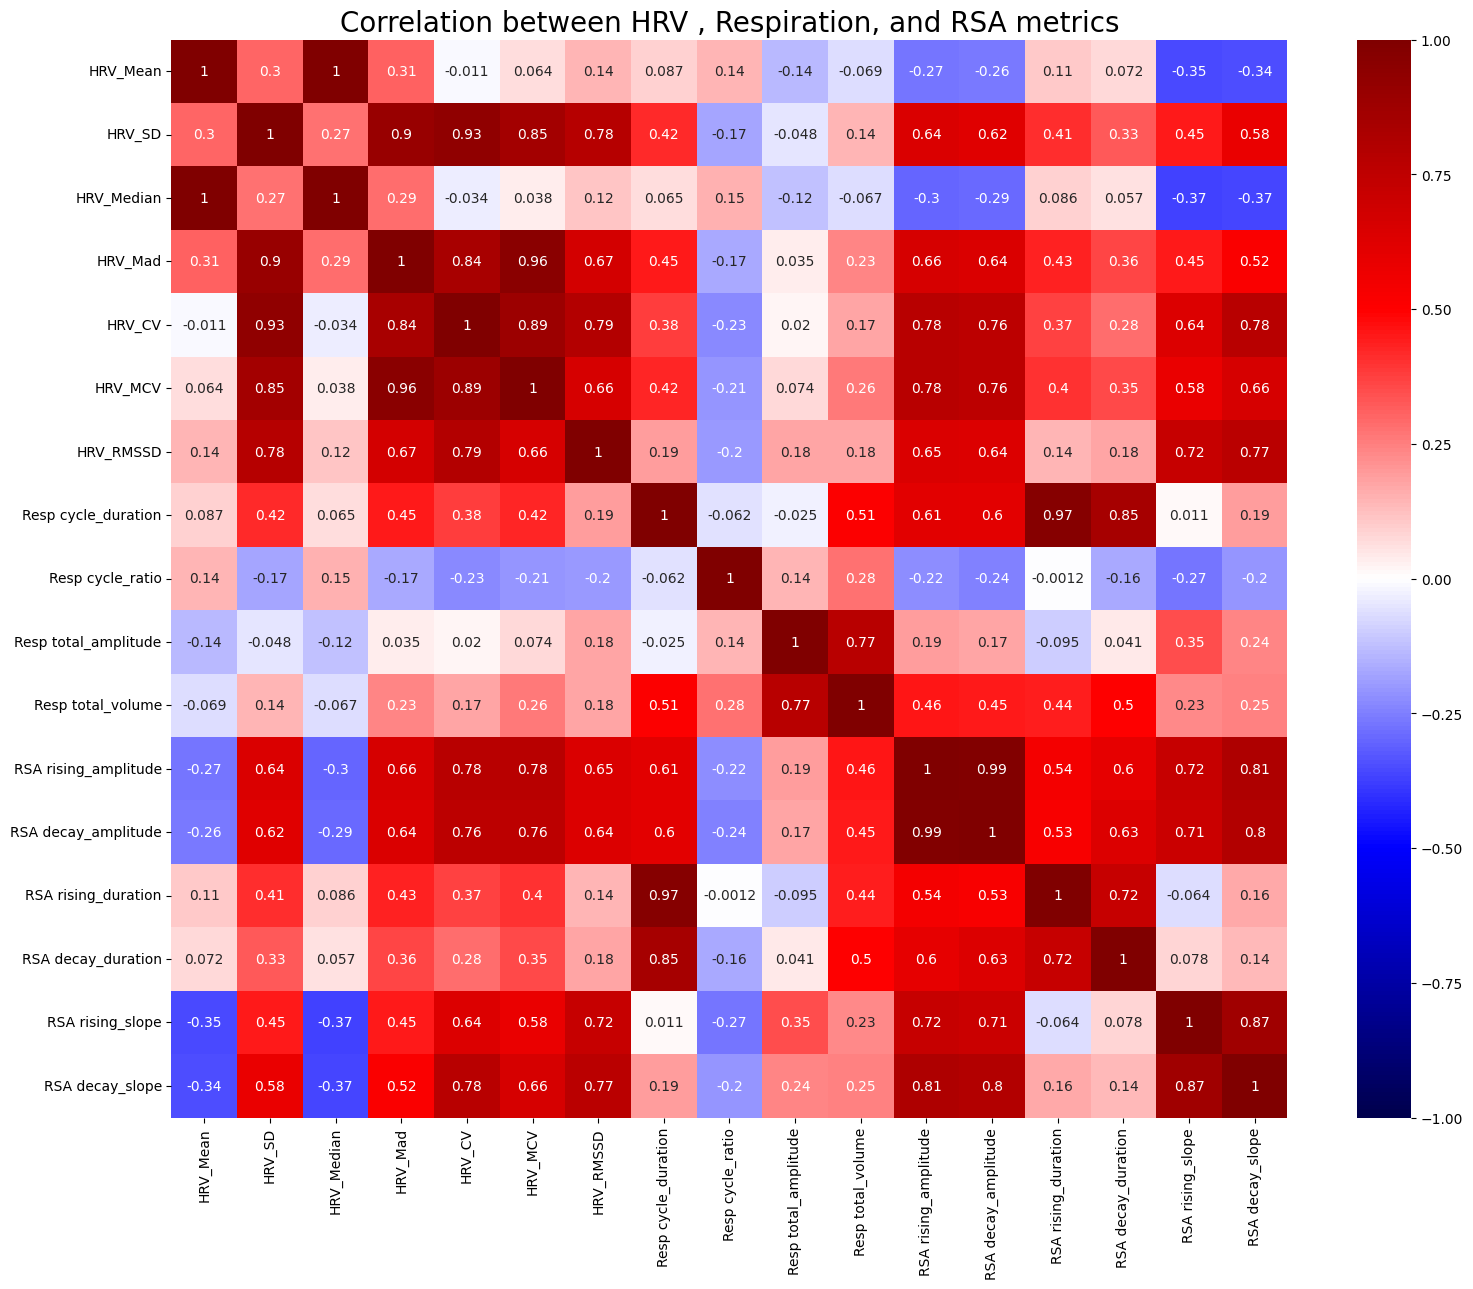

In [57]:
fig, ax = plt.subplots(figsize = (18,14))
sns.heatmap(concat.corr(method = 'spearman') , vmin = -1, vmax = 1, annot = True, cmap = 'seismic',ax=ax)
ax.set_title('Correlation between HRV , Respiration, and RSA metrics', fontsize = 20)
ax.set_ylabel(ax.get_ylabel(), fontsize =  18)
ax.set_xlabel(ax.get_xlabel(), fontsize =  18)
fig.savefig(base_folder / 'Figures' / 'Correlations' / 'hrv_resp_rsa.png', bbox_inches = 'tight', dpi = 300)

# PHASE FREQ CLUSTER BASED STATS

In [14]:
import mne

In [25]:
da = phase_freq_concat_job.get(global_key)['phase_freq_concat']

In [26]:
da

<xarray.DataArray 'phase_freq_concat' (participant: 30, session: 2,
                                       compress_cycle_mode: 12, chan: 13,
                                       freq: 67, phase: 200)>
[125424000 values with dtype=float64]
Coordinates:
  * participant          (participant) object 'P01' 'P02' 'P03' ... 'P30' 'P31'
  * session              (session) object 'odor' 'music'
  * compress_cycle_mode  (compress_cycle_mode) float64 0.1 0.2 0.25 ... 0.9 10.0
  * chan                 (chan) object 'F3' 'F4' 'C3' 'C4' ... 'Fz' 'Pz' 'Oz'
  * freq                 (freq) float64 4.0 4.098 4.199 ... 18.97 19.44 19.92
  * phase                (phase) float64 0.0 0.005025 0.01005 ... 0.995 1.0

In [363]:
da

<xarray.DataArray 'phase_freq_concat' (participant: 30, session: 2,
                                       compress_cycle_mode: 12, chan: 13,
                                       freq: 67, phase: 200)>
[125424000 values with dtype=float64]
Coordinates:
  * participant          (participant) object 'P01' 'P02' 'P03' ... 'P30' 'P31'
  * session              (session) object 'odor' 'music'
  * compress_cycle_mode  (compress_cycle_mode) float64 0.1 0.2 0.25 ... 0.9 10.0
  * chan                 (chan) object 'F3' 'F4' 'C3' 'C4' ... 'Fz' 'Pz' 'Oz'
  * freq                 (freq) float64 4.0 4.098 4.199 ... 18.97 19.44 19.92
  * phase                (phase) float64 0.0 0.005025 0.01005 ... 0.995 1.0

In [352]:
chan = 'F3'
q = 0.75
x1 = da.loc[:,'odor',q,chan,:,:]
x2 = da.loc[:,'music',q,chan,:,:]

In [353]:
pval = 0.05  # arbitrary
n_observations = da['participant'].size
df = n_observations - 1  # degrees of freedom for the test
thresh = scipy.stats.t.ppf(1 - pval/2 , df)  # two-tailed, t distribution
t_obs, clusters, cluster_pv,H0 = mne.stats.permutation_cluster_1samp_test(x2.values - x1.values, out_type = 'mask', tail =0, threshold = thresh)

stat_fun(H1): min=-1.193659 max=4.000857
Running initial clustering …
Found 77 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Text(0, 0.5, 'P-value')

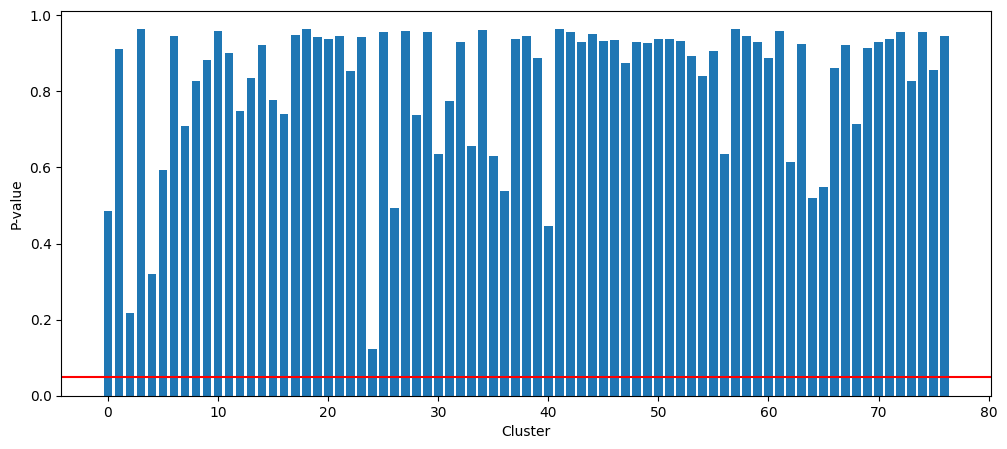

In [354]:
fig,ax= plt.subplots(figsize = (12,5))
ax.bar(range(cluster_pv.size), cluster_pv)
ax.axhline(0.05,color ='r')
ax.set_xlabel('Cluster')
ax.set_ylabel('P-value')

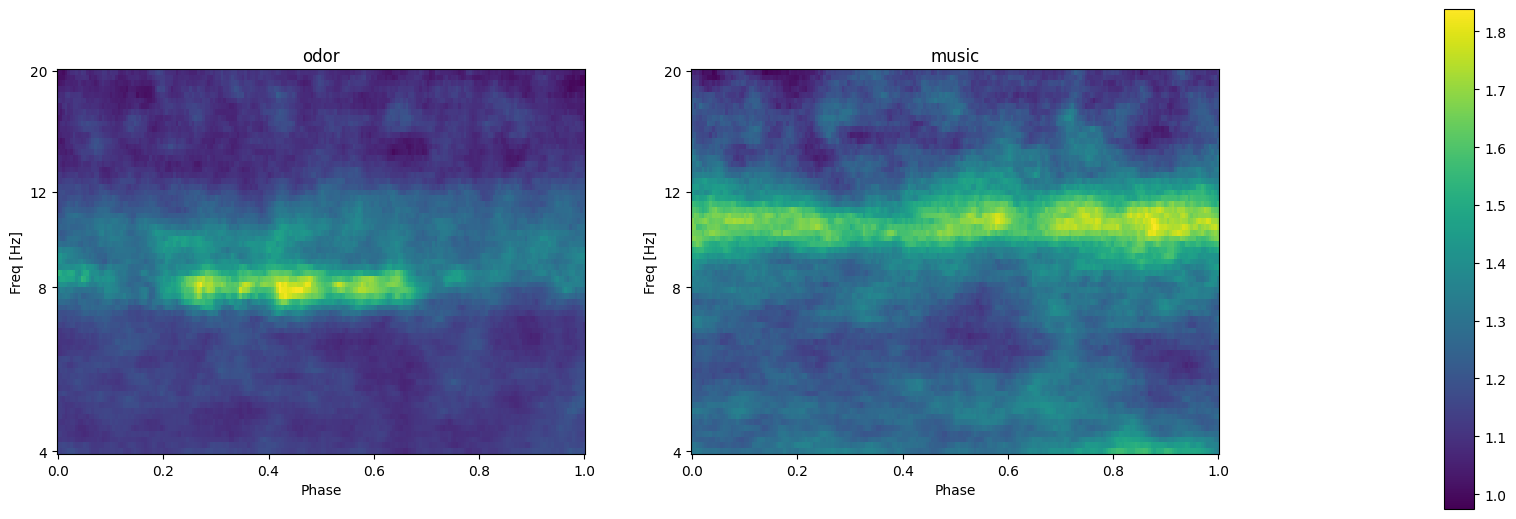

In [355]:
thresh = 0.05

f = da['freq'].values
phase = da['phase'].values
yticks = [4,8,12, 20]
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))

for i, x in enumerate([x1,x2]):
    ax = axs[i]
    if i == 0:
        cond = 'odor'
    else:
        cond = 'music'
        
    im = ax.pcolormesh(phase,f,x.mean('participant').values)
    ax.set_title(cond)
    ax.set_yscale('log')
    ax.set_yticks(ticks = yticks, labels = yticks)
    ax.minorticks_off()
    ax.set_xlabel('Phase')
    ax.set_ylabel('Freq [Hz]')
    
    for cluster, pval in zip(clusters,cluster_pv):
        if pval < thresh:
            ax.contour(phase,f,cluster, levels = 0, colors = 'k', corner_mask = True)   
            
ax_x_start = 1.05
ax_x_width = 0.02
ax_y_start = 0
ax_y_height = 1

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)

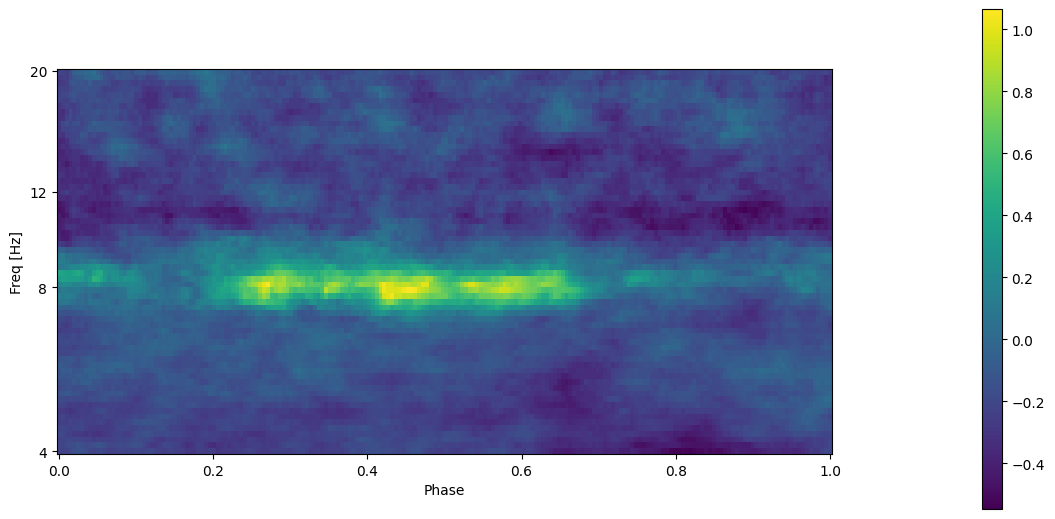

In [356]:
f = da['freq'].values
phase = da['phase'].values

fig, ax = plt.subplots( figsize = (10,5))

im = ax.pcolormesh(phase,f,x1.mean('participant').values-x2.mean('participant').values)
ax.set_yscale('log')

for cluster, pval in zip(clusters,cluster_pv):
    if pval < thresh:
        ax.contour(phase,f,cluster, levels = 0, colors = 'k', corner_mask = True)
            
ax_x_start = 1.05
ax_x_width = 0.02
ax_y_start = 0
ax_y_height = 1

ax.set_yticks(ticks = yticks, labels = yticks)
ax.minorticks_off()
ax.set_xlabel('Phase')
ax.set_ylabel('Freq [Hz]')

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)

In [360]:
bis = erp_concat_job.get(global_key)['erp_concat']

In [362]:
x1_time = bis.loc[:,'odor','F3','inspi_time',:,:]
x1_time

<xarray.DataArray 'erp_concat' (participant: 30, freq: 67, time: 1000)>
[2010000 values with dtype=float64]
Coordinates:
  * participant  (participant) object 'P01' 'P02' 'P03' ... 'P29' 'P30' 'P31'
    session      <U4 'odor'
    chan         <U2 'F3'
    center       <U10 'inspi_time'
  * freq         (freq) float64 4.0 4.098 4.199 4.303 ... 18.97 19.44 19.92
  * time         (time) float64 -5.0 -4.99 -4.98 -4.97 ... 4.96 4.97 4.98 4.99

In [380]:
da_stf = da.sel(compress_cycle_mode = 0.75).transpose('participant','session','freq','phase','chan')
diff = da_stf.sel(session = 'odor') - da_stf.sel(session = 'music')

In [381]:
diff

<xarray.DataArray 'phase_freq_concat' (participant: 30, freq: 67, phase: 200,
                                       chan: 13)>
array([[[[-8.71329553e-01,  7.42715625e-01,  3.07967680e-01, ...,
          -1.43161800e-01, -2.54760240e-01, -1.06820114e-01],
         [-8.76488888e-01,  7.05918472e-01,  2.71073971e-01, ...,
          -8.65173161e-02, -2.50362655e-01, -9.35300541e-02],
         [-8.47112027e-01,  7.75076171e-01,  2.59835698e-01, ...,
          -1.29214462e-01, -2.50979341e-01, -9.38853439e-02],
         ...,
         [-9.07295701e-01,  1.00825352e+00,  2.92613147e-01, ...,
          -2.94158042e-01, -3.44203579e-01,  8.69473159e-02],
         [-9.37272493e-01,  9.92781635e-01,  3.07213884e-01, ...,
          -2.44500992e-01, -3.72816917e-01,  3.10186429e-02],
         [-9.34863489e-01,  8.76754175e-01,  3.99448784e-01, ...,
          -1.19635137e-01, -3.87793370e-01,  1.22681245e-01]],

        [[-1.02112480e+00,  5.23399340e-01,  1.60766634e-01, ...,
          -3.22056793e-01, -3.17485740e-01,  1.97482082e-01],
         [-1.05720659e+00,  5.13646522e-01,  1.35724878e-01, ...,
          -2.39943985e-01, -3.10332269e-01,  1.44794093e-01],
         [-1.14418084e+00,  4.59002260e-01,  1.32329320e-01, ...,
          -2.77578063e-01, -3.27178557e-01,  8.58977058e-02],
...
         [-2.62942477e-01, -1.49987933e-01, -6.43214300e-01, ...,
          -7.87927527e-02, -5.26361523e-01, -4.70335347e-01],
         [-3.52902712e-01, -4.85947094e-02, -1.19361324e-01, ...,
          -3.40348130e-01, -4.73288659e-01, -8.92622031e-01],
         [-5.34257126e-01, -1.16315371e-01, -1.34354517e-01, ...,
           3.01583910e-02, -7.29890207e-01, -9.48360518e-01]],

        [[-4.24936453e-01, -3.23858470e-02,  1.48551966e-01, ...,
          -8.73111258e-02, -1.81470024e-01, -5.81842142e-01],
         [-5.48683958e-01, -3.73592738e-01,  1.87137826e-01, ...,
          -2.73174480e-01,  7.20721724e-02, -2.36607807e-01],
         [-1.06732554e+00, -5.84491063e-01, -4.37217049e-02, ...,
          -5.46683109e-01,  8.18866671e-02, -2.26772428e-01],
         ...,
         [-1.54947936e-01, -2.03149986e-01,  1.47340559e-01, ...,
           2.61472787e-01, -1.38837873e-01, -5.28338387e-01],
         [-2.27947312e-01, -2.02017748e-01,  1.54337311e-01, ...,
           1.26719829e-01, -3.63744744e-01, -9.33586136e-01],
         [-3.51804646e-01, -9.54083476e-02,  7.04845795e-02, ...,
          -2.50746083e-02, -5.46294885e-01, -9.92508798e-01]]]])
Coordinates:
  * participant          (participant) object 'P01' 'P02' 'P03' ... 'P30' 'P31'
    compress_cycle_mode  float64 0.75
  * chan                 (chan) object 'F3' 'F4' 'C3' 'C4' ... 'Fz' 'Pz' 'Oz'
  * freq                 (freq) float64 4.0 4.098 4.199 ... 18.97 19.44 19.92
  * phase                (phase) float64 0.0 0.005025 0.01005 ... 0.995 1.0

In [368]:
t_obs, clusters, cluster_pv,H0 = mne.stats.permutation_cluster_1samp_test(diff.values, out_type = 'mask')

Using a threshold of 2.045230
stat_fun(H1): min=-4.000857 max=4.183868
Running initial clustering …
Found 425 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

# REREF TESTS

In [4]:
eeg = preproc_job.get('P10_baseline')['eeg_clean']

In [25]:
t = eeg['time'].values
srate = eeg.attrs['srate']

In [5]:
eeg

<xarray.DataArray 'eeg_clean' (chan: 31, time: 600000)>
[18600000 values with dtype=float64]
Coordinates:
  * chan     (chan) object 'Fp1' 'Fz' 'F3' 'F7' 'FT9' ... 'FC2' 'F4' 'F8' 'Fp2'
  * time     (time) float64 0.0 0.001 0.002 0.003 ... 600.0 600.0 600.0 600.0
Attributes:
    srate:    1000

In [49]:
def reref(eeg, ref):
    if ref == 'Cz':
        print('no rereferencing')
        return eeg
    else:
        print(f'{ref} rereferencing')
        if ref == 'mean':
            eeg = eeg - eeg.mean('chan')
        elif '_' in ref:
            refs = ref.split('_')
            eeg = eeg - eeg.sel(chan = refs).mean('chan')
        else:
            eeg = eeg - eeg.sel(chan = ref)
    
    return eeg

In [50]:
# ref = 'Cz'
# ref = 'F4'
ref = 'TP9_TP10'
# ref = 'mean'

eeg_reref = reref(eeg, ref)

TP9_TP10 rereferencing


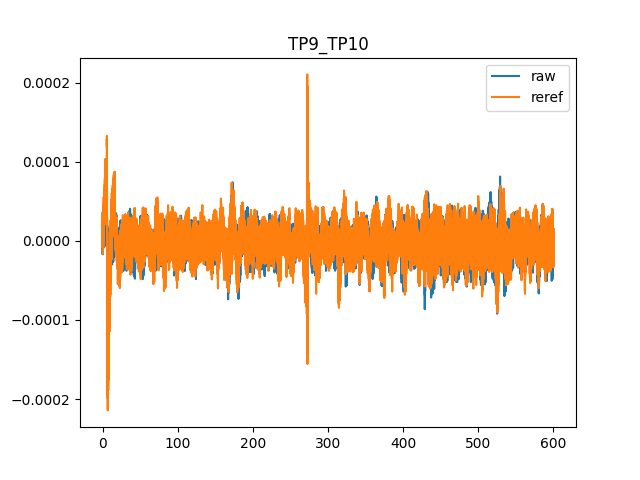

In [51]:
%matplotlib widget
chan_plot = 'F3'

fig, ax = plt.subplots()
ax.plot(t, eeg.sel(chan = chan_plot).values, label = 'raw')
ax.plot(t, eeg_reref.sel(chan = chan_plot).values, label = 'reref')
ax.set_title(ref)
ax.legend()
plt.show()

In [55]:
refs = ['Cz','TP9_TP10','mean']
lowest = 1
psds = None
for ref in refs:
    eeg_reref = reref(eeg, ref)
    f, Pxx = gh.spectre(eeg_reref.values, srate, lowest_freq = lowest)
    if psds is None:
        psds = gh.init_da({'ref':refs, 'chan':eeg_reref['chan'].values, 'f':f})
    psds.loc[ref, : ,:] = Pxx
    # psds = xr.DataArray(data = Pxx, dims = ['chan','f'], coords = {'chan':eeg_reref['chan'].values, 'f':f})

no rereferencing
TP9_TP10 rereferencing
mean rereferencing


In [56]:
psds.loc['Cz',:,:]

<xarray.DataArray (chan: 31, f: 2501)>
array([[7.89684732e-12, 3.43280223e-11, 1.02503175e-11, ...,
        1.39425937e-32, 1.39408792e-32, 6.97015520e-33],
       [2.57629021e-12, 1.23879603e-11, 6.48269077e-12, ...,
        2.62722433e-33, 2.62666376e-33, 1.31323747e-33],
       [8.81671649e-12, 4.62482316e-11, 1.39191552e-11, ...,
        1.97652632e-32, 1.97624630e-32, 9.88075844e-33],
       ...,
       [7.12256418e-12, 2.92996486e-11, 9.80040544e-12, ...,
        2.94720688e-33, 2.94602539e-33, 1.47281515e-33],
       [1.63421667e-11, 6.76866420e-11, 2.41558735e-11, ...,
        4.70907037e-33, 4.70670457e-33, 2.35295575e-33],
       [4.74270057e-12, 2.09476279e-11, 6.88310968e-12, ...,
        8.68506079e-33, 8.68399584e-33, 4.34182552e-33]])
Coordinates:
    ref      <U8 'Cz'
  * chan     (chan) object 'Fp1' 'Fz' 'F3' 'F7' 'FT9' ... 'FC2' 'F4' 'F8' 'Fp2'
  * f        (f) float64 0.0 0.2 0.4 0.6 0.8 ... 499.2 499.4 499.6 499.8 500.0

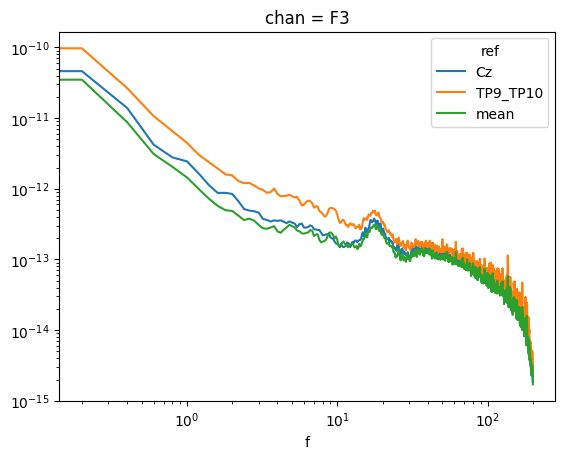

In [58]:
%matplotlib inline
psds.loc[:,'F3',:200].plot.line(x='f', hue = 'ref', yscale = 'log', xscale = 'log')

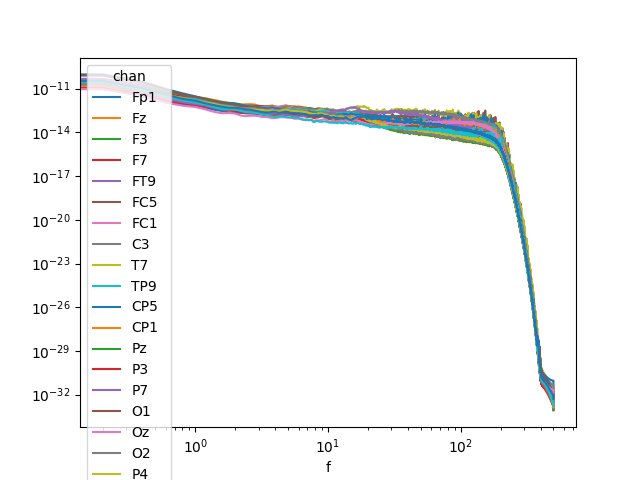

In [34]:
plt.figure()
psds.plot.line(x = 'f', hue = 'chan', yscale = 'log', xscale = 'log')
plt.show()

In [ ]:
fig, ax =  plt.subplots()
ax.loglog(f, Pxx)
plt.show()

# RECONSTRUCT ONLINE REF

In [35]:
file = data_path / 'P01' / 'signaux' / 'subDB01_baseline.vhdr'

In [36]:
raw = mne.io.read_raw_brainvision(file, preload = True)

Extracting parameters from /home/valentin/smb4k/CRNLDATA/crnldata/cmo/Etudiants/NBuonviso2023_Emosens3_OdeurSon_Valentin_Matthias/Data/P01/signaux/subDB01_baseline.vhdr...
Setting channel info structure...
Reading 0 ... 621299  =      0.000 ...   621.299 secs...


/tmp/ipykernel_18532/4010210659.py:1: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(file, preload = True)
/tmp/ipykernel_18532/4010210659.py:1: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload = True)
/tmp/ipykernel_18532/4010210659.py:1: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (500.00 Hz, Nyquist limit) will be stored.
  raw = mne.io.read_raw_brainvision(file, preload = True)
/tmp/ipykernel_18532/4010210659.py:1: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['ECG', 'GSR', 'RespiNasale', 'RespiVentrale']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these

In [48]:
raw.ch_names

['Fp1',
 'Fz',
 'F3',
 'F7',
 'FT9',
 'FC5',
 'FC1',
 'C3',
 'T7',
 'TP9',
 'CP5',
 'CP1',
 'Pz',
 'P3',
 'P7',
 'O1',
 'Oz',
 'O2',
 'P4',
 'P8',
 'TP10',
 'CP6',
 'CP2',
 'C4',
 'T8',
 'FT10',
 'FC6',
 'FC2',
 'F4',
 'F8',
 'Fp2',
 'ECG',
 'GSR',
 'RespiNasale',
 'RespiVentrale']

If a scalp electrode was used as reference but was not saved alongside the raw data (reference channels often aren’t), you may wish to add it back to the dataset before re-referencing. For example, if your EEG system recorded with channel Fp1 as the reference but did not include Fp1 in the data file, using set_eeg_reference() to set (say) Cz as the new reference will then subtract out the signal at Cz without restoring the signal at Fp1. In this situation, you can add back Fp1 as a flat channel prior to re-referencing using add_reference_channels()

In [37]:
raw_reref = raw.copy()

In [60]:
ref_choice = 'average'
raw_reref, ref_data = mne.set_eeg_reference(raw_reref, ref_channels = 'average', copy = True, ch_type = 'eeg')

Applying average reference.
Applying a custom ('EEG',) reference.


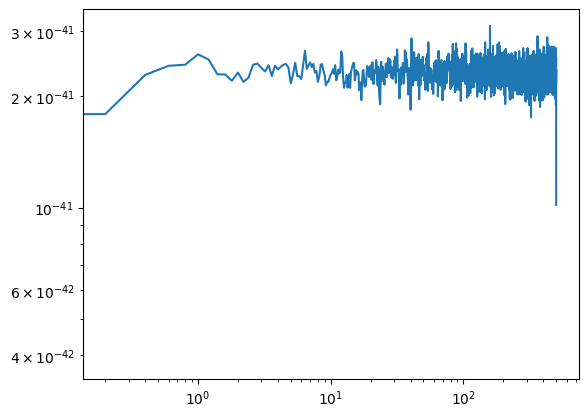

In [67]:
f, Pxx = gh.spectre(ref_data, srate = 1000, lowest_freq = 1)
fig, ax = plt.subplots()
ax.loglog(f, Pxx)
plt.show()

In [59]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 31 EEG, 4 misc
 custom_ref_applied: False
 dig: 34 items (3 Cardinal, 31 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-03-06 12:16:12 UTC
 nchan: 35
 projs: []
 sfreq: 1000.0 Hz
>

In [53]:
raw_reref

<RawBrainVision | subDB01_baseline.eeg, 35 x 621300 (621.3 s), ~166.0 MB, data loaded>

In [54]:
raw_reref.ch_names

['Fp1',
 'Fz',
 'F3',
 'F7',
 'FT9',
 'FC5',
 'FC1',
 'C3',
 'T7',
 'TP9',
 'CP5',
 'CP1',
 'Pz',
 'P3',
 'P7',
 'O1',
 'Oz',
 'O2',
 'P4',
 'P8',
 'TP10',
 'CP6',
 'CP2',
 'C4',
 'T8',
 'FT10',
 'FC6',
 'FC2',
 'F4',
 'F8',
 'Fp2',
 'ECG',
 'GSR',
 'RespiNasale',
 'RespiVentrale']

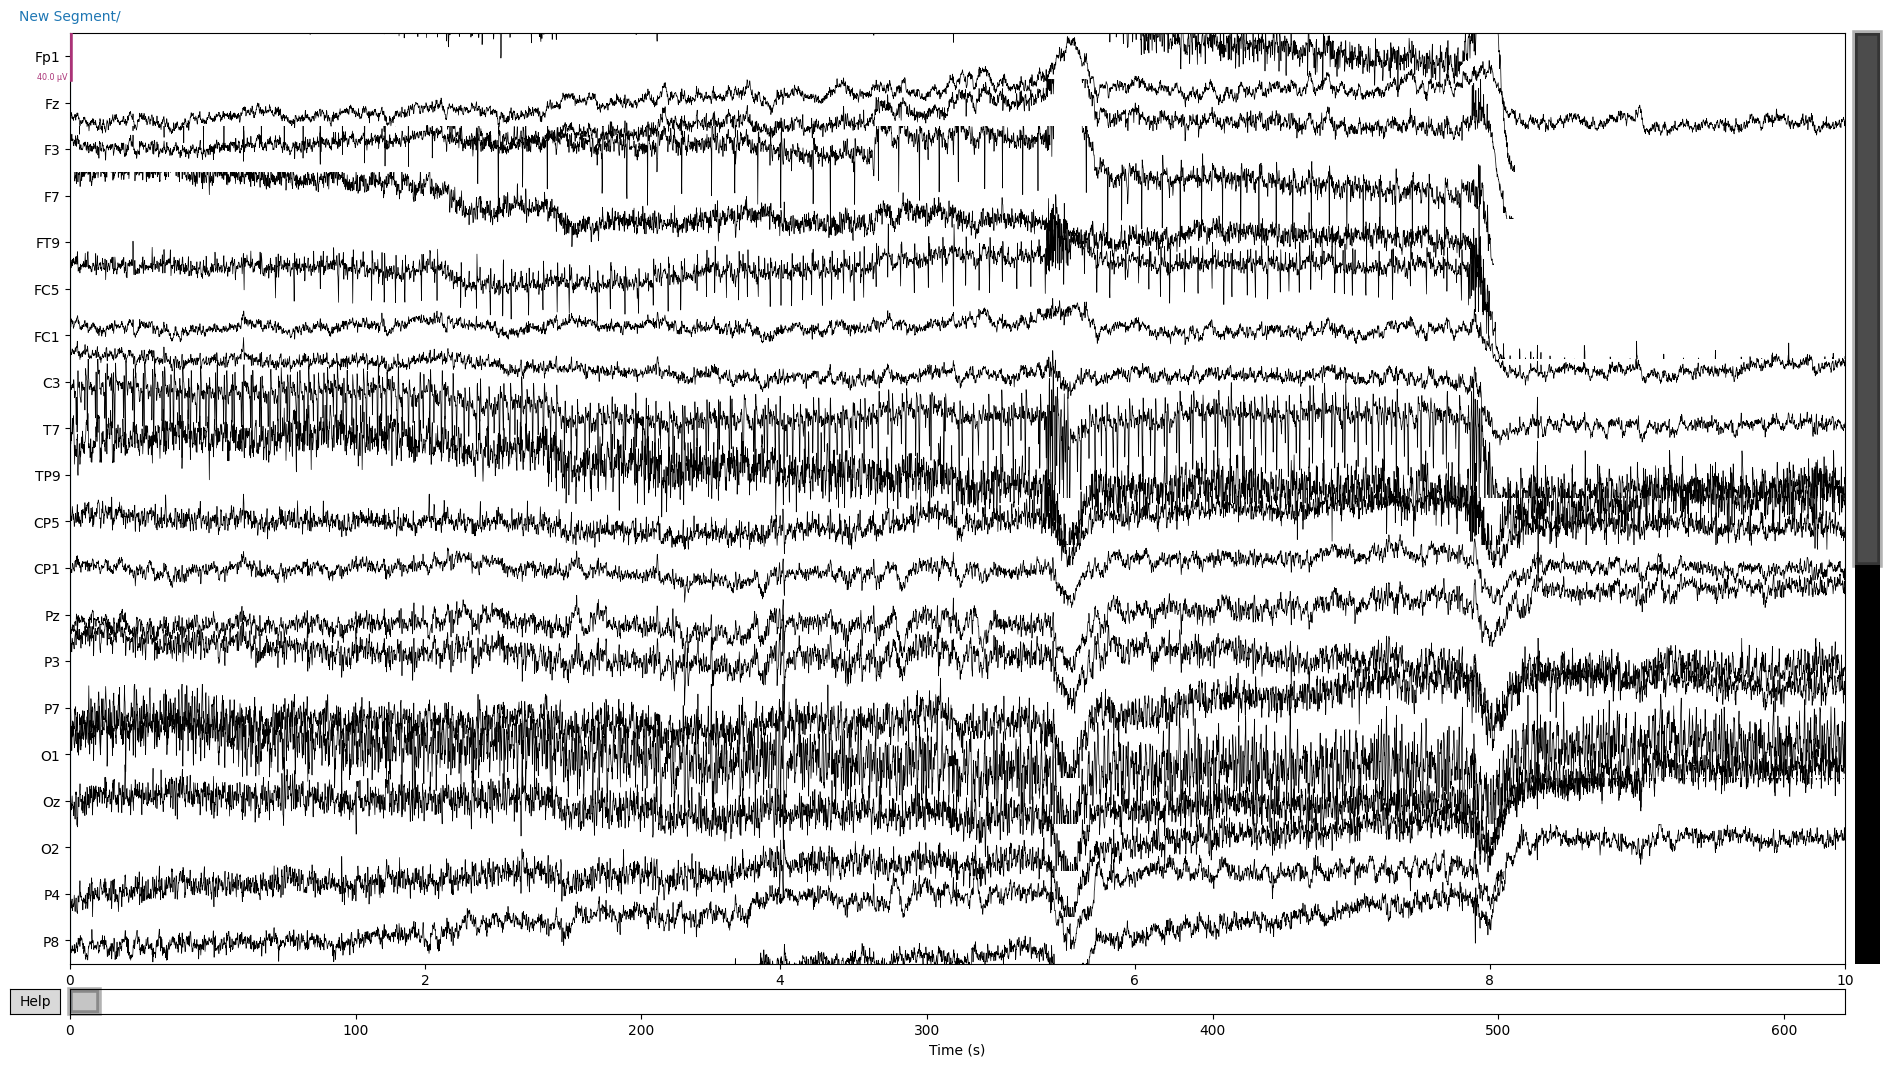

In [55]:
raw_reref.plot()
plt.show()

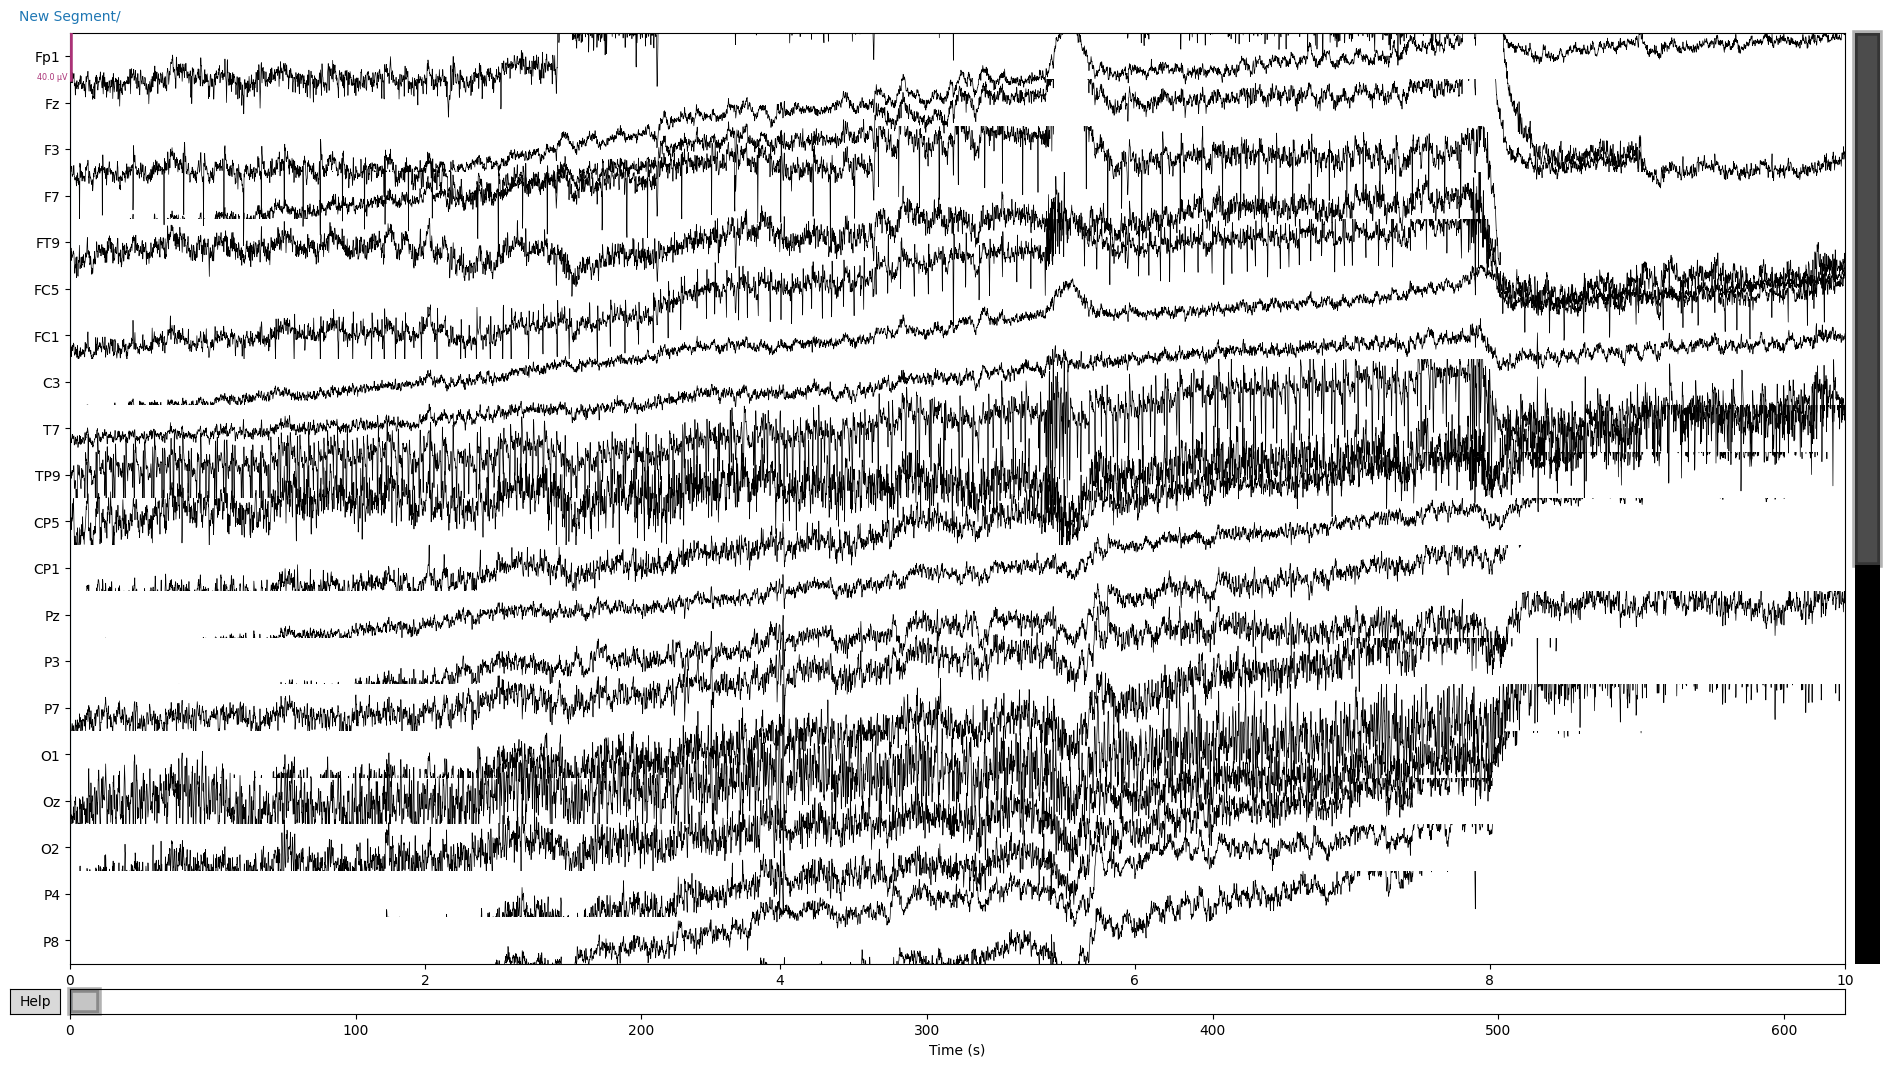

In [44]:
raw.plot()
plt.show()

# CYCLE SIGNAL FIG

In [15]:
p = cycle_signal_params

scale_factor = 30

def get_N_resp_cycles(run_keys):
    concat = []
    for run_key in run_keys:
        participant, session = run_key.split('_')
        resp = respiration_features_job.get(run_key).to_dataframe()
        concat.append(resp)

    all_resp = pd.concat(concat)

    N_cycles = all_resp.value_counts(subset = ['participant','session']).to_frame().reset_index().rename(columns ={'count':'N'}).set_index(['participant','session'])
    return N_cycles

N_cycles = get_N_resp_cycles(run_keys)
N_cycles_pooled = N_cycles.groupby(['session']).sum(numeric_only = True)

fig_folder = base_folder / 'Figures' / 'Cycle_Signal' / 'whole_signal'


# CONCAT
all_cycle_signal = None

for run_key in run_keys:
    
    participant, session = run_key.split('_')
    ds = cycle_signal_job.get(run_key)
    
    cycle_signal = ds['cycle_signal']
    
    if all_cycle_signal is None:
        all_cycle_signal = init_nan_da({'participant':subject_keys, 
                                        'session':session_keys,
                                      'chan':cycle_signal.coords['chan'].values,
                                      'phase':cycle_signal.coords['phase'].values
                                     })
        
    all_cycle_signal.loc[participant,session,:,:] = cycle_signal.values



In [16]:
sub = 'P11'
chan = 'C3'
data = all_cycle_signal.sel(participant = sub, chan = chan)

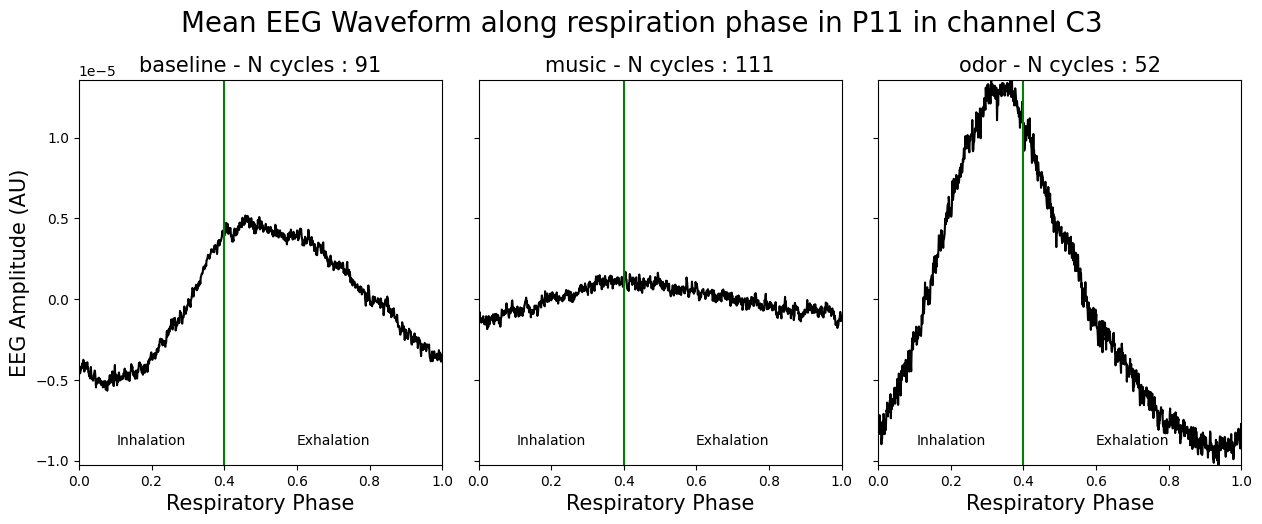

In [32]:
ncols = data['session'].size

vmin = data.min()
vmax = data.max()

fig, axs = plt.subplots(ncols = ncols, figsize = (15,5), sharey = True)
fig.subplots_adjust(wspace = 0.1)
fig.suptitle(f'Mean EEG Waveform along respiration phase in {sub} in channel {chan}', fontsize = 20, y = 1.02)

for c, ses in enumerate(data['session'].values):
    ax = axs[c]
    ax.plot(data['phase'].values, data.loc[ses,:].values, color = 'k')
    ax.axvline(0.4, color = 'g')
    N = N_cycles.loc[(sub, ses),'N']
    ax.set_title(f'{ses} - N cycles : {N}', fontsize = 15)
    ax.set_xlabel('Respiratory Phase', fontsize = 15)
    if c == 0:
        ax.set_ylabel('EEG Amplitude (AU)', fontsize = 15)
    ax.set_ylim(vmin, vmax)
    ax.set_xlim(0,1)
    ax.text(x=0.2,y= - 0.9*1e-5, s= 'Inhalation', ha = 'center')
    ax.text(x=0.7, y=- 0.9*1e-5, s='Exhalation', ha = 'center')

fig.savefig(fig_folder / 'example.png', bbox_inches = 'tight', dpi = 300)


# CYCLE SIGNAL TOPOPLOT VIDEO MODULATION

In [79]:
import cv2
import glob
import tqdm

In [3]:
pos = get_pos()

In [62]:
sub = 'P11'
sess = ['baseline','music','odor']
das = None
for ses in sess:
    da = cycle_signal_job.get(sub, ses)['cycle_signal']
    if das is None:
        das = gh.init_da({'ses':sess, 'chan':da.coords['chan'].values, 'phase':da.coords['phase'].values})
    das.loc[ses,:,:] = da.values

In [64]:
eeg = das.sel(chan = eeg_chans)

In [80]:
phases = np.arange(0, eeg['phase'].size, 1)

vmin = eeg.min()
vmax = eeg.max()

chan_line = 'Cz'
chan_vmin = das.loc[:,chan_line,:].min()
chan_vmax = das.loc[:,chan_line,:].max()

resp_chan = 'resp_nose'
resp_vmin = das.loc[:,resp_chan,:].min()
resp_vmax = das.loc[:,resp_chan,:].max()

folder = base_folder / 'Figures' / 'Frames_video_modulation'

loop = tqdm.tqdm(phases)

for phase in loop:
    
    # if phase == 3:
    #     break
    
    fig, axs = plt.subplots(nrows = 3, ncols = len(sess), figsize = (20,15))
    
    for c, ses in enumerate(sess):
        ax = axs[0,c]
        im, cn = mne.viz.plot_topomap(data = eeg[c,:,int(phase)].values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(ses)
        
        ax = axs[1,c]
        chan_sig = eeg.loc[ses,chan_line,:].values
        ax.plot(chan_sig, color = 'k')
        ax.scatter(phase, chan_sig[int(phase)], color = 'r', lw=3)
        ax.axvline(400, color = 'g')
        ax.set_title(chan_line)
        ax.axis('off')
        ax.set_ylim(chan_vmin, chan_vmax)

        ax = axs[2,c]
        resp_sig = das.loc[ses,'resp_nose',:].values
        ax.plot(resp_sig, color = None, lw = 2)
        ax.scatter(phase, resp_sig[int(phase)], color = 'r', lw=3)
        ax.axvline(400, color = 'g')
        ax.axis('off')
        ax.set_ylim(resp_vmin, resp_vmax)
    
    file =  folder / f'im_{phase}.png'
    fig.savefig(file, bbox_inches = 'tight')
    plt.close('all')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:58<00:00,  1.08s/it]


In [88]:
step = 4
images = [f'{str(folder)}/im_{i}.png' for i in np.arange(0, phases[-1], step)]

In [89]:
video_duration = 10
n_images = len(images)
fps = int(n_images / video_duration)
print(fps)

25


In [90]:
image_folder = base_folder / 'Figures' / 'Frames_video_modulation'
video_name = base_folder / 'Figures' / 'Frames_video_modulation' / 'video.avi'
video_name = str(video_name)

frame = cv2.imread(images[0])
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, fps, (width,height))

for image in images:
    video.write(cv2.imread(image))

cv2.destroyAllWindows()
video.release()

In [94]:
len(glob.glob(f'{str(folder)}/im*.png'))

1000